In [328]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [329]:
# set directory paths
root = '../../..'
images_dir = os.path.join(root, 'data/subset_valid/images/')
gt_bbox_dir = os.path.join(root, 'data/subset_valid/gt/')
pred_bbox_dir = os.path.join(root, 'data/subset_valid/pred/')

In [337]:
# set constants
gt_format = 'xywh_norm'
pred_format = 'y1x1y2x2_norm'
iou_thres = 0.0
output_path = 'subset_validation.csv'

In [338]:
image_fn = os.listdir(images_dir)
pred_bbox_fn = os.listdir(pred_bbox_dir)
gt_bbox_fn = os.listdir(gt_bbox_dir)

In [339]:
def parse_txt (label_fp, format_bbox, dataset):
    """Obtain x_min, y_min, x_max, and y_max of bounding box from txt file
    Args:
        label_fp (str): filepath to bounding box .txt file in detect.py output format
        format_bbox: 'x1y1x2y2' or 'xywh_norm' or 'x1y1x2y2_norm'
        dataset: 'predicted' or 'ground_truth'
    Returns:
        coords (numpy array)
        conf (float, returned only if dataset == 'predicted')
    """
    if format_bbox == 'y1x1y2x2_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                x_min = int(float(vals[1]) * 419)
                y_min = int(float(vals[2]) * 419)
                x_max = int(float(vals[3]) * 419)
                y_max = int(float(vals[0]) * 419)
                coords = np.array([y_min, x_min, y_max, x_max])
                if dataset == 'ground_truth':
                    return coords
                elif dataset == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf
    elif format_bbox == 'xywh_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                norm_x = float(vals[1])
                norm_y = float(vals[2])
                norm_w = float(vals[3])
                norm_h = float(vals[4])
                x_min = int((norm_x * 419) - ((norm_w * 419) / 2))
                y_min = int((norm_y * 419) - ((norm_h * 419) / 2))
                x_max = int((norm_x * 419) + ((norm_w * 419) / 2))
                y_max = int((norm_y * 419) + ((norm_h * 419) / 2))
                coords = np.array([x_min, y_min, x_max, y_max])
                if dataset == 'ground_truth':
                    return coords
                elif dataset == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf

In [340]:
def calc_CT_IoU (bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Adapted from: https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    Args:
        bb1: [x1,y1,x2,y2]
        bb2: [x1,y1,x2,y2]    
    The (x1, y1) position is at the top left corner (or the bottom right - either way works).
    The (x2, y2) position is at the bottom right corner (or the top left).
    Returns:
        intersection_over_union, a float in [0, 1]
    """
    y_max, x_min, y_min, x_max = bb2
    bb2 = [x_min, y_min, x_max, y_max]
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    # Determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # Compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [342]:
# create dictionaries of ground_truth bboxes,  predicted bboxes, and confidence
ground_truth_dict = {}
for fn in gt_bbox_fn:
    bbox = parse_txt(os.path.join(gt_bbox_dir, fn), gt_format, 'ground_truth')
    ground_truth_dict[fn.replace('.txt', '.png')] = bbox
predicted_dict = {}
conf_dict = {}
for fn in pred_bbox_fn:
    print(fn)
    bbox, conf = parse_txt(os.path.join(pred_bbox_dir, fn), pred_format, 'predicted')
    predicted_dict[fn.replace('.txt', '.png')] = bbox
    conf_dict[fn.replace('.txt', '.png')] = conf

116143.txt
116334.txt
116288.txt
116035.txt
116287.txt
116986.txt
116881.txt
116569.txt
116888.txt
116085.txt
116456.txt
116784.txt
116978.txt
116939.txt
116534.txt
116444.txt
116326.txt
1162-1306_not_a_dam.txt
116685.txt
116184.txt
116506.txt
116374.txt
116069.txt
116958.txt
116692.txt
116901.txt
11668.txt
1168-1323_not_a_dam.txt
116683.txt
116241.txt
116755.txt
116432.txt
116993.txt
116458.txt
116375.txt
116094.txt
116048.txt
116827.txt
116294.txt
116083.txt
116161.txt
116299.txt
116495.txt
116189.txt
116947.txt
116168.txt
116694.txt
116076.txt
116043.txt
116879.txt
116704.txt
116412.txt
116385.txt
116271.txt
11641.txt
116194.txt
11634.txt
116264.txt
116186.txt
116796.txt
116972.txt
1160-1259_not_a_dam.txt
116826.txt
116648.txt
116563.txt
1167-1296_not_a_dam.txt
116891.txt
116372.txt
116841.txt
1169-1534_not_a_dam.txt
116257.txt
1169.txt
116806.txt
116542.txt
116492.txt
116997.txt
116687.txt
116181.txt
116875.txt
116309.txt
116011.txt
#116841.txt#


IndexError: list index out of range

In [327]:
# build dataframe of image, ground_truth bboxes, predicted bboxes, and confidence
data = {'img_id' : image_fn}
detect_df = pd.DataFrame(data, columns=['img_id'])
detect_df['img_id'] = detect_df['img_id'].replace('.png', '')
print('created dataframe')
detect_df['gt_bbox'] = detect_df['img_id'].map(pd.Series(ground_truth_dict))
detect_df['gt_format'] = 'x1y1x2y2'
print('added ground truth boxes')
detect_df['pred_bbox'] = detect_df['img_id'].map(pd.Series(predicted_dict))
detect_df['pred_format'] = 'y2,x1,y1,x2'
print('added predicted boxes')
detect_df['confidence'] = detect_df['img_id'].map(pd.Series(conf_dict))
print('added confidence')

created dataframe
added ground truth boxes
added predicted boxes
added confidence


In [296]:
# add ground_truth bbox size to dataframe
detect_df['gt_size'] = detect_df.apply(
    lambda row: None if row.gt_bbox is None else int((row.gt_bbox[2] - row.gt_bbox[0]) * (row.gt_bbox[3] - row.gt_bbox[1])), 
    axis=1
)
print('added size')

added size


In [292]:
# add IoU - cameratraps to dataframe
CT_iou_dict = {}
for fn in predicted_dict:
    if 'not_a_dam' not in fn:
        CT_iou = calc_CT_IoU(ground_truth_dict[fn], predicted_dict[fn])
        CT_iou_dict[fn] = CT_iou
    else:
        CT_iou_dict[fn] = None
detect_df['CT_iou'] = detect_df['img_id'].map(pd.Series(CT_iou_dict))
print('added CT_iou')

added CT_iou


In [325]:
# add result (tp, fp, fn, tn)
detect_df['tp'] = np.where((detect_df.CT_iou > iou_thres), 1, 0)
detect_df['fp'] = np.where((detect_df.CT_iou <= iou_thres) | (detect_df.pred_bbox.notnull() & detect_df.gt_bbox.isnull()), 1, 0)
detect_df['fn'] = np.where((detect_df.CT_iou <= iou_thres) | (detect_df.pred_bbox.isnull() & detect_df.gt_bbox.notnull()), 1, 0)
detect_df['result'] = detect_df.apply(
    lambda row: 'tp' if row.tp == 1 else 'fp+fn' if (row.fp == 1) & (row.fn == 1) else 'fp' if (row.fp == 1) else 'fn' if (row.fn == 1) else 'tn',
    axis=1
)
detect_df = detect_df.drop(['tp', 'fp', 'fn'], axis=1)
print('added result')

added result


In [326]:
detect_df = detect_df.set_index('img_id')
print(detect_df)#.sort_values(by='confidence', ascending=False))

KeyError: 'img_id'

In [289]:
# visualize
print(predicted_dict.keys())

dict_keys(['116143.png', '116334.png', '116288.png', '116035.png', '116287.png', '116986.png', '116881.png', '116569.png', '116888.png', '116085.png', '116456.png', '116784.png', '116978.png', '116939.png', '116534.png', '116444.png', '116326.png', '1162-1306_not_a_dam.png', '116685.png', '116184.png', '116506.png', '116374.png', '116069.png', '116958.png', '116692.png', '116901.png', '11668.png', '1168-1323_not_a_dam.png', '116683.png', '116241.png', '116755.png', '116432.png', '116993.png', '116458.png', '116375.png', '116094.png', '116048.png', '116827.png', '116294.png', '116083.png', '116161.png', '116299.png', '116495.png', '116189.png', '116947.png', '116168.png', '116694.png', '116076.png', '116043.png', '116879.png', '116704.png', '116412.png', '116385.png', '116271.png', '11641.png', '116194.png', '11634.png', '116264.png', '116186.png', '116796.png', '116972.png', '1160-1259_not_a_dam.png', '116826.png', '116648.png', '116563.png', '1167-1296_not_a_dam.png', '116891.png', '1

[18, 73, 92, 83, 66, 88, 12, 28, 38, 62, 27, 41, 99, 4, 21, 69, 19, 63, 67, 84]


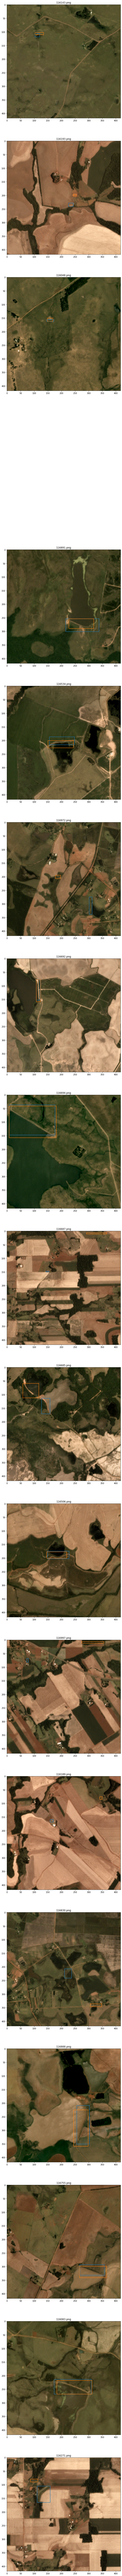

In [323]:
# visualize
from shapely.geometry import box
fig = plt.figure(figsize=(12,240))
randlist = random.sample(range(0, 107), 20)
k = 0
for i in randlist:
    img_fn = os.listdir(images_dir)[i]
    k += 1
    if 'not_a_dam' not in img_fn:
        img_fp = os.path.join(images_dir, img_fn)
        img = mpimg.imread(img_fp)
        gt_coords = ground_truth_dict[img_fn]
        gt_bbox = box(gt_coords[0], gt_coords[1], gt_coords[2], gt_coords[3])
        x_gt,y_gt = gt_bbox.exterior.xy
        pred_coords = predicted_dict[img_fn]
        pred_bbox = box(pred_coords[1], pred_coords[2], pred_coords[3], pred_coords[0])
        x_pr,y_pr = pred_bbox.exterior.xy
        ax = fig.add_subplot(20,1,k)
        ax.set_title(img_fn)
        ax.imshow(img)
        ax.plot(x_gt,y_gt)
        ax.plot(x_pr,y_pr)

# ground truth in blue
# predicted in orange